In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from sklearn import preprocessing
from tqdm import tqdm
import random
import tensorflow as tf

In [2]:
os.listdir("./data")

['004#biGRU_diff.csv',
 'dlstm_diff.zip',
 'decode_train_neg.csv',
 'test2_match.csv',
 'test_match.csv',
 'decode_train_neg_spe.csv',
 'sqli_trian.zip',
 'train_match.csv',
 'sqli_submit_9878.json',
 'sqli_test_1',
 'test.csv',
 'train.csv',
 'test_neg_spe.csv',
 'sqli_test_2',
 'test_pos.csv',
 'sqli_train',
 'test_neg_pos.csv',
 'dlstm_diff.csv',
 'decode_train_neg_pos.csv',
 'decode_train_pos.csv',
 '004#dlstm_diff.csv',
 'test2.csv',
 'sqli_test_2.zip',
 'test_neg.csv',
 'sqli_test_1-.zip',
 '007#bi-GRU-MaxPool.csv']

In [3]:
tf.reset_default_graph()

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = 50

# Network Parameters
seq_max_len = 300 # Sequence max length
vocab_len = 69
n_hidden = 32 # hidden layer num of features
n_classes = 2 # linear sequence or not

# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, vocab_len])
y = tf.placeholder("float", [None, n_classes])
# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None,])

# # Define weights
# weights = {
#     'out': tf.Variable(tf.random_normal([100, n_classes], seed=2018))
# }
# biases = {
#     'out': tf.Variable(tf.random_normal([n_classes], seed=2018))
# }



# Get lstm cell output, providing 'sequence_length' will perform dynamic calculation.
with tf.variable_scope("LSTM") as scope:
    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, state_is_tuple=True)
    print("lstm_cell", lstm_cell)
#     init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
#     print("init_state", lstm_cell)
    outputs, states = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32)
    print("outputs", outputs)
#     print("states", states)
    
with tf.variable_scope("softmax"):
    softmax_w = tf.get_variable("softmax_w",
                                shape=[n_hidden, n_classes],
                                initializer=tf.truncated_normal_initializer(stddev=0.05, seed=2018),
                                dtype=tf.float32)
    softmax_b = tf.get_variable("softmax_b",
                                shape=[n_classes],
                                initializer=tf.constant_initializer(value=0.),
                                dtype=tf.float32)
    reshape = tf.reshape(outputs, [-1, n_hidden])
    xw_plus_b = tf.nn.xw_plus_b(reshape, softmax_w, softmax_b)
    print("xw_plus_b:", xw_plus_b)
    logits = tf.reshape(xw_plus_b, [-1, seq_max_len, n_classes])
    print("logits:", logits)
    logits_softmax = tf.nn.softmax(logits)
    print("logits_softmax:", logits_softmax)
    
with tf.variable_scope("output"):
    # Hack to build the indexing and retrieve the right output.
    batch_size_ = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size_) * seq_max_len + (seqlen - 1)
    # Indexing
    pred = tf.gather(tf.reshape(logits, [-1, n_classes]), index)
    print("pred", pred)


with tf.name_scope("loss"):
#     print(outputs)
    # Linear activation, using outputs computed above
#     pred = tf.matmul(weights['out'], outputs) + biases['out']

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    

with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
with tf.name_scope("valid"):
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

lstm_cell <tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell object at 0x7ff02db45ef0>
outputs Tensor("LSTM/rnn/transpose:0", shape=(?, 300, 32), dtype=float32)
xw_plus_b: Tensor("softmax/xw_plus_b:0", shape=(?, 2), dtype=float32)
logits: Tensor("softmax/Reshape_1:0", shape=(?, 300, 2), dtype=float32)
logits_softmax: Tensor("softmax/Reshape_3:0", shape=(?, 300, 2), dtype=float32)
pred Tensor("output/Gather:0", shape=(?, 2), dtype=float32)


/home/renxinzhang/.conda/envs/tf-gpu-1.3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [4]:
vocab = [v for v in ' !"#$%&\'()*+,-./0123456789:;<=>?@[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~']
print("lable encoder vocab")
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(vocab)
print(label_encoder.classes_)

lable encoder vocab
[' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1'
 '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' '[' '\\' ']'
 '^' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{' '|' '}' '~']


In [5]:
def get_train_neg():
    train_pd = pd.read_csv("./data/test_neg.csv")
    train_pd = train_pd.dropna()
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [0] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [6]:
def get_train_neg_pos():
    train_pd = pd.read_csv("./data/test_neg_pos.csv")
    train_pd = train_pd.dropna()
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [0] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [7]:
def get_train_neg_sep():
    train_pd = pd.read_csv("./data/test_neg_spe.csv")
    train_pd = train_pd.dropna()
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [0] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [8]:
def get_train_pos():
    train_pd = pd.read_csv("./data/test_pos.csv")
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [1] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
#     return x_batch_pad[6000:], x_batch_size[6000:], y_batch_pad[6000:]
#     return x_batch_pad[:9969+1], x_batch_size[:9969+1], y_batch_pad[:9969+1]
    return x_batch_pad[11:], x_batch_size[11:], y_batch_pad[11:]

In [91]:
# test_data, test_seqlen, test_label = get_train_pos()
# test_data, test_seqlen, test_label = get_train_neg()
# test_data, test_seqlen, test_label = get_train_neg_pos()
test_data, test_seqlen, test_label = get_train_neg_sep()
test_data, test_seqlen, test_label = np.array(test_data), np.array(test_seqlen), np.array(test_label)
print(test_data.shape, test_seqlen.shape, test_label.shape)

100%|██████████| 16307/16307 [00:00<00:00, 509896.64it/s]

get word_list & label encoder



100%|██████████| 16307/16307 [00:00<00:00, 246020.90it/s]

padding & one-hot x data


padding & one-hot y data
(16307, 300, 69) (16307,) (16307, 2)


In [92]:
tmp = np.argmax(test_data[0], axis=1)
tmp = [label_encoder.inverse_transform(item) for item in tmp]
# tmp = ["".join(list(item)).strip() for item in tmp]
"".join(list(tmp)).strip()

'mpcqsmhxsoh7hxfqyp08yom7emmn0pkz-vh*hmcxymgxt'

In [93]:
'-2758"))) union all select 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432--  and ((("qwlp"="qwlp'

'-2758"))) union all select 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432--  and ((("qwlp"="qwlp'

In [94]:
len(test_data)//5000

3

In [95]:
LOG_DIR = "./logs/010_BasicModel/"
saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
module_file = tf.train.latest_checkpoint(LOG_DIR)

test_pred = ''
# Start training
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
with tf.Session(config=config) as sess:
    
    saver.restore(sess, module_file)

    for i in range((len(test_data)//5000)+1):
#         print(i*5000,(i+1)*5000)
        feed_dict_tmp={}
        feed_dict_tmp[x] = test_data[i*5000:(i+1)*5000]
        feed_dict_tmp[y] = test_label[i*5000:(i+1)*5000]
        feed_dict_tmp[seqlen] = test_seqlen[i*5000:(i+1)*5000]
        if i == 0:
            test_pred, test_acc, test_output = sess.run([pred, accuracy, logits_softmax], feed_dict=feed_dict_tmp)
#             print(len(feed_dict_tmp[x]))
            print("\t",i*5000,(i+1)*5000,"Testing Accuracy:", test_acc)
            test_acc = test_acc * len(feed_dict_tmp[x]) / len(test_data) 
        else:
            test_pred_tmp, test_acc_tmp, test_output_tmp = sess.run([pred, accuracy, logits_softmax], feed_dict=feed_dict_tmp)
            test_pred = np.vstack((test_pred, test_pred_tmp))
            test_output = np.vstack((test_output, test_output_tmp))
            test_acc += test_acc_tmp * len(feed_dict_tmp[x]) / len(test_data) 
#             print(len(feed_dict_tmp[x]))
            print("\t",i*5000,(i+1)*5000,"Testing Accuracy:", test_acc_tmp)
            
    # Calculate accuracy
#     test_data = sqli_batch.test_x
#     test_label = sqli_batch.test_y
#     test_seqlen = sqli_batch.test_size
#     test_pred, test_acc, test_output = sess.run([pred, accuracy, logits_softmax], feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
#     print("Testing Accuracy:", test_acc)
    print("Testing Accuracy:", test_acc)

INFO:tensorflow:Restoring parameters from ./logs/010_BasicModel/sqli.ckpt-500
	 0 5000 Testing Accuracy: 0.9962
	 5000 10000 Testing Accuracy: 0.9946
	 10000 15000 Testing Accuracy: 0.9964
	 15000 20000 Testing Accuracy: 0.996174
Testing Accuracy: 0.995768412022


In [98]:
LOG_DIR = "./logs/010_BasicModel-2/"
saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
module_file = tf.train.latest_checkpoint(LOG_DIR)

test_pred = ''
# Start training
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
with tf.Session(config=config) as sess:
    
    saver.restore(sess, module_file)

    for i in range((len(test_data)//5000)+1):
#         print(i*5000,(i+1)*5000)
        feed_dict_tmp={}
        feed_dict_tmp[x] = test_data[i*5000:(i+1)*5000]
        feed_dict_tmp[y] = test_label[i*5000:(i+1)*5000]
        feed_dict_tmp[seqlen] = test_seqlen[i*5000:(i+1)*5000]
        if i == 0:
            test_pred, test_acc, test_output = sess.run([pred, accuracy, logits_softmax], feed_dict=feed_dict_tmp)
#             print(len(feed_dict_tmp[x]))
            print("\t",i*5000,(i+1)*5000,"Testing Accuracy:", test_acc)
            test_acc = test_acc * len(feed_dict_tmp[x]) / len(test_data) 
        else:
            test_pred_tmp, test_acc_tmp, test_output_tmp = sess.run([pred, accuracy, logits_softmax], feed_dict=feed_dict_tmp)
            test_pred = np.vstack((test_pred, test_pred_tmp))
            test_output = np.vstack((test_output, test_output_tmp))
            test_acc += test_acc_tmp * len(feed_dict_tmp[x]) / len(test_data) 
#             print(len(feed_dict_tmp[x]))
            print("\t",i*5000,(i+1)*5000,"Testing Accuracy:", test_acc_tmp)
            
    # Calculate accuracy
#     test_data = sqli_batch.test_x
#     test_label = sqli_batch.test_y
#     test_seqlen = sqli_batch.test_size
#     test_pred, test_acc, test_output = sess.run([pred, accuracy, logits_softmax], feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
#     print("Testing Accuracy:", test_acc)
    print("Testing Accuracy:", test_acc)

INFO:tensorflow:Restoring parameters from ./logs/010_BasicModel-2/sqli.ckpt-500
	 0 5000 Testing Accuracy: 0.9962
	 5000 10000 Testing Accuracy: 0.9956
	 10000 15000 Testing Accuracy: 0.9966
	 15000 20000 Testing Accuracy: 0.996174
Testing Accuracy: 0.996136331402


In [99]:
test_pred.shape

(16307, 2)

In [100]:
from sklearn.utils.extmath import softmax

test_pred_label = np.argmax(test_pred, 1)
test_real_label = np.argmax(test_label, 1)
test_diff = test_pred_label != test_real_label
test_diff_index = np.where(test_diff == True)[0]
print("diff len:", len(test_diff_index))

# test_data = sqli_batch.test_x
# test_label = sqli_batch.test_y
# test_seqlen = sqli_batch.test_size

diff_x = test_data[test_diff_index]
diff_x = np.argmax(diff_x, 2)

diff_y = test_label[test_diff_index]
diff_y = np.argmax(diff_y, 1)

test_pred_softmax = softmax(test_pred)
# test_pred_softmax = test_pred
pred_y = test_pred_softmax[test_diff_index]
pred_y = [item[1] for item in pred_y]
pred_class = test_pred_label[test_diff_index]

diff_x = [label_encoder.inverse_transform(item) for item in diff_x]
diff_value = ["".join(list(item)).strip() for item in diff_x]

diff_pd = pd.DataFrame(diff_value, columns=['value'])
diff_pd['label'] = diff_y
diff_pd['pred'] = pred_y
diff_pd['plabel'] = pred_class
diff_pd['id'] = test_diff_index
diff_pd.to_csv("./result/neg_sep_diff_2.csv", index=False)
diff_pd

diff len: 63


,value,label,pred,plabel,id
0,-1,0,0.929773,1,42
1,"{""command"":""action"",""action"":""getstate"",""actio...",0,0.631872,1,478
2,-2,0,0.945508,1,707
3,"""""style",0,0.961305,1,714
4,";3dvsoflele#_#$udsrul'rkvkhkuo=)fr=_|?gf:o;h,i...",0,0.973257,1,825
5,"""""",0,0.971287,1,988
6,1+||+1+=+1+into+outfile+'result.txt',0,0.908763,1,1253
7,+aa'+/++1+<+'3,0,0.977558,1,1383
8,' < ',0,0.990163,1,1600
9,"{""labelid"":""649564"",""count"":50,""type"":""new""}",0,0.777863,1,1976


In [29]:
show_index = 9950
showitem = test_data[show_index]
showitem_len = test_seqlen[show_index]
print(showitem.shape)
showitem = np.argmax(showitem, 1)
print(showitem.shape)
heatmap_x = [label_encoder.inverse_transform(item) for item in showitem]
heatmap_x = heatmap_x[:showitem_len]
print(showitem_len)
heatmap_y = test_output[show_index][:showitem_len]
heatmap_y = [[row[1] for row in heatmap_y]]

(300, 69)
(300,)
263


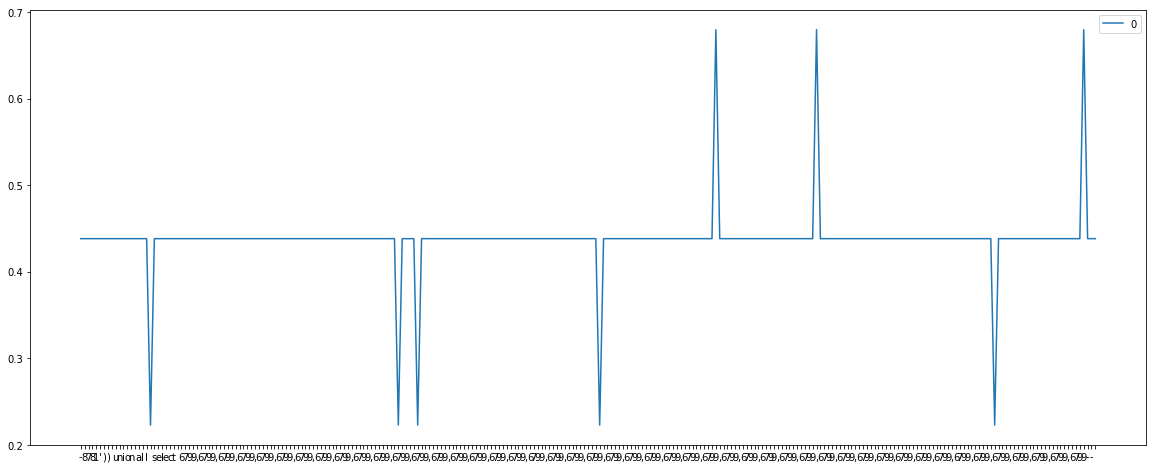

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
for i in range(1):
    plt.plot(heatmap_y[i][:len(heatmap_x)], label=str(i))
xticks = range(0,len(heatmap_x))
ax.set_xticks(xticks) # major ticks
ax.set_xticklabels(heatmap_x)   # labels should be 'unicode'
plt.legend(loc='upper right')
plt.show()